In [1]:
import dask, concurrent.futures, time, warnings, os, re, pickle
from osgeo import gdal
import os
import requests as r
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import rioxarray as riox
import time
import xarray as xr
from urllib.request import urlopen
from xml.etree.ElementTree import parse,fromstring
from pandas import to_datetime
from rasterio.crs import CRS
from datetime import datetime, timedelta
from netrc import netrc
from pyproj import Proj
from src.hls_funcs import fetch
from src.hls_funcs.masks import mask_hls, shp2mask, bolton_mask
from src.hls_funcs.indices import ndvi_func
from src.hls_funcs.smooth import smooth_xr, despike_ts_xr
import cartopy.crs as ccrs
from rasterio.plot import show
from src.hls_funcs.predict import pred_bm
import dask.diagnostics
import matplotlib.pyplot as plt

In [2]:
t00 = time.time()
os.chdir('/project/cper_neon_aop/hls_cog/')

In [3]:
cper_f = os.path.join('data/ground/cper_pastures_2017_clip.shp')
mod_bm = pickle.load(open('src/models/CPER_HLS_to_VOR_biomass_model_lr_simp.pk', 'rb'))

2021
   setting up temporary Local cluster on HPC...


/project/cper_neon_aop/conda_envs/hls_cog_env/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/sean.kearney/proxy/8787/status,
Dashboard: /user/sean.kearney/proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 23.44 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42890,Workers: 8
Dashboard: /user/sean.kearney/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 23.44 GiB
Comm: tcp://127.0.0.1:42457,Total threads: 2
Dashboard: /user/sean.kearney/proxy/41429/status,Memory: 2.93 GiB
Nanny: tcp://127.0.0.1:43705,


...completed in 3.0 secs
total elasped time: 0.04 mins

   fetching data...


tornado.application - ERROR - Uncaught exception GET /workers/ws (::1)
HTTPServerRequest(protocol='http', host='jupyterhub.scinet.usda.gov', method='GET', uri='/workers/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/project/cper_neon_aop/conda_envs/hls_cog_env/lib/python3.9/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/project/cper_neon_aop/conda_envs/hls_cog_env/lib/python3.9/site-packages/tornado/web.py", line 3173, in wrapper
    return method(self, *args, **kwargs)
  File "/project/cper_neon_aop/conda_envs/hls_cog_env/lib/python3.9/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


...completed in 795.0 secs
total elasped time: 13.3 mins

   closing local HPC cluster and scaling up to new cluster...


<Client: 'tcp://10.1.9.148:43654' processes=56 threads=112, memory=104.16 GiB>

...completed in 26.0 secs
total elasped time: 13.73 mins

   applying secondary cloud mask...
...completed in 41.0 secs
total elasped time: 14.44 mins

   computing NDVI for available dates...
...completed in 2.0 secs
total elasped time: 14.48 mins

   computing biomass for available dates...
...completed in 28.0 secs
total elasped time: 14.95 mins

   removing dates with > 75% cloud cover...
...completed in 1.0 secs
total elasped time: 14.96 mins

   creating daily template for output...
...completed in 3.0 secs
total elasped time: 15.01 mins

   interpolating daily NDVI...
...completed in 91.0 secs
total elasped time: 16.52 mins



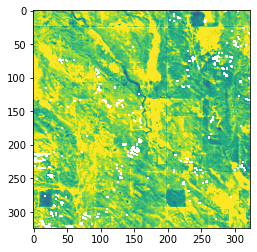

   interpolating daily biomass...
...completed in 83.0 secs
total elasped time: 17.91 mins



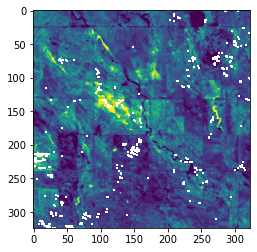

   adding pasture data as a spatial coordinate...
...completed in 1.0 secs
total elasped time: 17.93 mins



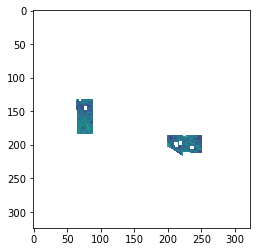

   subsetting data to 2021 only and saving to disk as geotiffs...
...completed in 3.0 secs
total elasped time: 18.0 mins

   computing daily averages for individual pastures and saving to disk...
...completed in 115.0 secs
total elasped time: 19.93 mins

checking output dataframe NDVI data


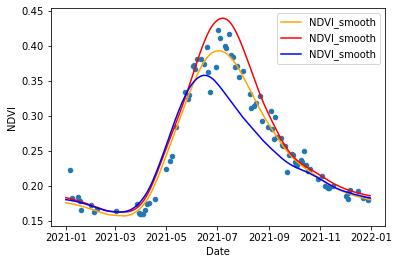

checking output dataframe biomass data


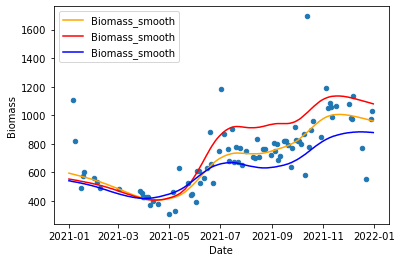

all analysis complete for year 2021. Finished in 19.94 mins

total elasped time for all years: 19.94 mins

closing cluster
-----------------------------------------------------------------------




In [4]:
for yr in range(2021, 2022):
    print(yr)
    t0 = time.time()
    cluster_loc = 'hpc'
    t1 = time.time()
    if cluster_loc == 'local':
        print('   setting up Local cluster...')
        from dask.distributed import LocalCluster, Client
        import dask
        aws=False
        fetch.setup_env(aws=aws)
        cluster = LocalCluster(n_workers=8, threads_per_worker=2)
        client = Client(cluster)
        display(client)
    elif cluster_loc == 'coiled':
        import coiled
        aws=True
        fetch.setup_env(aws=aws)
        s3_cred = fetch.setup_netrc(creds=['spkearney', '1mrChamu'], aws=aws)
        coiled.create_software_environment(
        name="hls_cog_coiled",
        conda="hls_cog_coiled_env.yaml")
        cluster = coiled.Cluster(
            name="hls_cog_coiled",
            software="kearney-sp/hls_cog_coiled",
            n_workers=5,
            worker_cpu=2,
            scheduler_cpu=2,
            backend_options={"region": "us-west-2"},
            environ=dict(GDAL_DISABLE_READDIR_ON_OPEN='FALSE', 
                       #AWS_NO_SIGN_REQUEST='YES',
                       GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
                       GDAL_SWATH_SIZE='200000000',
                       VSI_CURL_CACHE_SIZE='200000000',
                       CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                       GDAL_HTTP_UNSAFESSL='YES',
                       GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                       GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'),
                       AWS_REGION='us-west-2',
                       AWS_SECRET_ACCESS_KEY=s3_cred['secretAccessKey'],
                       AWS_ACCESS_KEY_ID=s3_cred['accessKeyId'],
                       AWS_SESSION_TOKEN=s3_cred['sessionToken'])
        )
        client = Client(cluster)
        display(client)
    elif cluster_loc == 'hpc':
        from dask.distributed import LocalCluster, Client
        import dask_jobqueue as jq
        import dask
        print('   setting up temporary Local cluster on HPC...')
        aws=False
        fetch.setup_env(aws=aws)
        dask.config.set({'distributed.dashboard.link': '/user/{USER}/proxy/{port}/status'})
        cluster = LocalCluster(n_workers=8, threads_per_worker=2)
        client = Client(cluster)
        display(client)
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    df_cper = gpd.read_file(cper_f)
    df_cper = df_cper.dissolve(by='Past_Name_').reset_index().rename(columns={'Past_Name_': 'Pasture'})

    bounds_latlon = list(df_cper.to_crs('EPSG:4236').total_bounds)
    bounds_latlon

    start_date = str(yr - 1) + "-11-01"
    end_date = str(yr + 1) + "-03-01"

    # set the date range for analysis
    date_rng = pd.date_range(start=start_date, end=end_date)

    print('   fetching data...')
    t1 = time.time()
    # fetch the COG data from the AWS bucket
    data_dict = {'date_range': [str(date_rng.min().date()), str(date_rng.max().date())]}
    hls_ds = fetch.get_hls(hls_data=data_dict,
                           bbox_latlon=bounds_latlon, 
                           lim=500,
                           aws=aws)
    hls_ds = hls_ds.where(hls_ds['eo:cloud_cover'] != None, drop=True)
    hls_ds = hls_ds.where(hls_ds['eo:cloud_cover'] < 90, drop=True)
    #hls_ds = hls_ds.loc[dict(x=slice(517587.0, 527283.0), y=slice(4524402.0, 4514699.0))].chunk({'y': -1,
    #                                                                                             'x': -1,
    #                                                                                             'time':1})
    hls_mask = mask_hls(hls_ds['FMASK'])
    idx_load_try = 0
    max_load_try = 5
    while idx_load_try < max_load_try:
        try:
            hls_ds = hls_ds.where(hls_mask == 0).load()
            idx_load_try = max_load_try
        except RuntimeError as e:            
            if e.args[0] == 'Set changed size during iteration':
                print('Warning: error with cluster set size. Restarting cluster and retrying ' + \
                  str(idx_load_try+1) + ' of ' + str(max_load_try))
                cluster.close()
                client.close()
                cluster = LocalCluster(n_workers=8, threads_per_worker=2)
                client = Client(cluster)
            else:
                print('Warning: error connecting to lpdaac. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
            idx_load_try += 1
        except rio.errors.RasterioIOError as e:
            print('Warning: error loading data. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
            idx_load_try += 1
            
    hls_ds['time'] = hls_ds['time'].dt.date
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    if cluster_loc == 'hpc':
        print('   closing local HPC cluster and scaling up to new cluster...')
        t1 = time.time()
        client.close()
        cluster.close()
        partition='brief-low',#'short','debug', 'mem', 'mem-low',
        num_processes = 4
        num_threads_per_processes = 2
        mem = 1.0*num_processes*num_threads_per_processes#*1.25
        n_cores_per_job = num_processes*num_threads_per_processes
        clust = jq.SLURMCluster(queue=partition,
                                processes=num_processes,
                                cores=n_cores_per_job,
                                memory=str(mem)+'GB',
                                interface='ib0',
                                #interface='enp24s0f0',
                                local_directory='$TMPDIR',
                                death_timeout=30,
                                walltime='02:00:00',
                                job_extra=["--output=/dev/null","--error=/dev/null"])
        client=Client(clust)
        #Scale Cluster 
        num_jobs=16
        clust.scale(jobs=num_jobs)
        try:
            client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
        except TimeoutError as e:
            print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
            print(e)
            pass
        display(client)
        #num_jobs=16
        #clust.scale(jobs=num_jobs)
        #client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
        print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
        print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    print('   applying secondary cloud mask...')
    hls_ds = hls_ds.chunk({'time': -1, 'y': 50, 'x': 50})
    t1 = time.time()
    hls_bolton_mask = bolton_mask(hls_ds)
    hls_ds = hls_ds.where(hls_bolton_mask == 0).compute()
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    print('   computing NDVI for available dates...')
    hls_ds = hls_ds.chunk({'time': 20, 'y': 50, 'x': 50})
    t1 = time.time()
    # create ndvi array
    xr_ndvi = ndvi_func(hls_ds).compute()
    xr_ndvi.name = 'NDVI'
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    print('   computing biomass for available dates...')
    t1 = time.time()
    # create biomass array
    xr_bm = hls_ds.map_blocks(pred_bm, template=hls_ds['NIR1'],
                              kwargs=dict(model=mod_bm)).where(hls_ds['NIR1'].notnull()).compute()

    xr_bm.name = 'Biomass'
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    print('   removing dates with > 75% cloud cover...')
    t1 = time.time()
    partial_mask = (xr_ndvi.count(dim=['y', 'x'])/np.product(xr_ndvi.shape[1:])) > 0.25
    xr_ndvi = xr_ndvi.where(partial_mask, drop=True)
    xr_bm = xr_bm.where(partial_mask, drop=True)
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    print('   creating daily template for output...')
    t1 = time.time()
    # create an output Dataset template with all dates
    dat_out = xr.Dataset(coords={'y': hls_ds.y,
                                 'x': hls_ds.x,
                                 'time': date_rng}).chunk({'y': 5, 'x': 5, 'time':-1})

    # assign the time coordinate to the output
    dat_out['time'] = dat_out['time'].dt.date

    # create empty arrays for filling variable values
    dat_out = dat_out.assign(NDVI=(['time', 'y', 'x'],
                                   np.zeros((dat_out.dims['time'], 
                                             dat_out.dims['y'], 
                                             dat_out.dims['x'])) * np.nan),
                             Biomass=(['time', 'y', 'x'],
                                   np.zeros((dat_out.dims['time'], 
                                             dat_out.dims['y'], 
                                             dat_out.dims['x'])) * np.nan)
                             )

    # combine the available NDVI data with the output Dataset template
    dat_out_ds = xr.merge([xr_ndvi.groupby('time').mean(),
                           xr_bm.groupby('time').mean(), 
                           dat_out], compat='override').chunk({'y': 5, 'x': 5, 'time':-1})
    dat_out_ds.attrs = hls_ds.attrs
    dat_out_ds['NDVI_despike'] = despike_ts_xr(dat_out_ds['NDVI'].chunk({'y': 5, 'x': 5, 'time':-1}), 
                                               dat_thresh=0.07, 
                                               mask_outliers=False,
                                               iters=2,
                                               dims=['time'])
    dat_out_ds['NDVI_smooth'] = smooth_xr(dat_out_ds['NDVI_despike'], 
                                          dims=['time'], 
                                          kwargs={'double': True, 'limit': 91})
    dat_out_ds['Biomass_despike'] = despike_ts_xr(dat_out_ds['Biomass'].chunk({'y': 5, 'x': 5, 'time':-1}),
                                                  dat_thresh=150, 
                                                  mask_outliers=True,
                                                  z_thresh=5.0,
                                                  iters=2,
                                                  dims=['time'])
    dat_out_ds['Biomass_smooth'] = smooth_xr(dat_out_ds['Biomass_despike'], 
                                             dims=['time'],
                                             kwargs={'double': True, 'limit': 91})
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    t1 = time.time()
    print('   interpolating daily NDVI...')
    dat_out_ds['NDVI_smooth'] = dat_out_ds['NDVI_smooth'].compute()
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    show(dat_out_ds['NDVI_smooth'].isel(time=200), vmin=0.10, vmax=0.35)

    t1 = time.time()
    print('   interpolating daily biomass...')
    dat_out_ds['Biomass_smooth'] = dat_out_ds['Biomass_smooth'].compute()
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    show(dat_out_ds['Biomass_smooth'].isel(time=200), vmin=250, vmax=1000)

    t1 = time.time()
    print('   adding pasture data as a spatial coordinate...')
    cper_info = df_cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
    past_dict[0] = 'UNK'
    cper_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]
    cper_mask = shp2mask(shp=cper_mask_shp, 
                         transform=rio.Affine(30.0, 0.0, dat_out_ds.x.min(), 0.0, -30.0, dat_out_ds.y.max()), 
                         outshape=dat_out_ds['NDVI'].shape[1:], 
                         xr_object=dat_out_ds['NDVI'])
    past_mask = np.array([past_dict[i] for i in cper_mask.values.flatten()]).reshape(cper_mask.shape)
    dat_out_ds = dat_out_ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
    dat_out_ds = dat_out_ds.set_coords('Pasture')
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    show(dat_out_ds['NDVI_smooth'].isel(time=200).where(dat_out_ds['Pasture'].isin(['19N', '15E'])))

    t1 = time.time()
    print('   subsetting data to ' + str(yr) + ' only and saving to disk as geotiffs...')
    yr_mask = dat_out_ds['time'].astype(np.datetime64).dt.year == yr
    dat_out_ds.sel(time=yr_mask)

    dat_out_ds.sel(
        time=yr_mask)['NDVI_smooth'].astype('float32').rio.to_raster('output/hls_ndvi/cper_hls_ndvi_' + str(yr) + '.tif')
    dat_out_ds.sel(
        time=yr_mask)['Biomass_smooth'].astype('int16').rio.to_raster('output/hls_biomass/cper_hls_bm_' + str(yr) + '.tif')
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')
    
    t1 = time.time()
    print('   computing daily averages for individual pastures and saving to disk...')
    df_out_cper = dat_out_ds.sel(
        time=yr_mask).mean(dim=['y', 'x']).to_dataframe()

    df_out_cper['Pasture'] = 'CPER'
    df_out_cper = df_out_cper.drop(columns='epsg').reset_index()

    df_out_pasts = dat_out_ds.sel(
        time=yr_mask).groupby('Pasture').mean(dim='stacked_y_x').to_dataframe()

    df_out_pasts = df_out_pasts.drop(columns='epsg').reset_index()

    df_out_all = pd.concat([df_out_cper, df_out_pasts])
    df_out_all.rename(columns={'time': 'Date'}, inplace=True)

    df_out_all.loc[:,
                   [c for c in df_out_all.columns if 'NDVI' in c]] = df_out_all.loc[:,
                                                                                    [c for c in df_out_all.columns if 'NDVI' in c]].apply(
        lambda x: round(x, 4))
    df_out_all.loc[:,
                   [c for c in df_out_all.columns if 'Biomass' in c]] = df_out_all.loc[:,
                                                                                    [c for c in df_out_all.columns if 'Biomass' in c]].apply(
        lambda x: round(x, 0))

    df_out_all[df_out_all['Pasture'] != 'UNK'].sort_values(
        ['Pasture', 'Date']).to_csv('output/cper_hls_means/cper_hls_means_' + str(yr) + '.csv', index=False)
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')
    
    
    print('checking output dataframe NDVI data')
    ax1 = df_out_all[df_out_all['Pasture']=='CPER'].plot('Date', 'NDVI_smooth', c='orange')
    df_out_all[df_out_all['Pasture']=='CPER'].plot.scatter('Date', 'NDVI', ax=ax1)
    df_out_all[df_out_all['Pasture']=='19N'].plot('Date', 'NDVI_smooth', c='red', ax=ax1)
    df_out_all[df_out_all['Pasture']=='15E'].plot('Date', 'NDVI_smooth', c='blue', ax=ax1)
    plt.show()
    plt.close()
    
    print('checking output dataframe biomass data')
    ax2 = df_out_all[df_out_all['Pasture']=='CPER'].plot('Date', 'Biomass_smooth', c='orange')
    df_out_all[df_out_all['Pasture']=='CPER'].plot.scatter('Date', 'Biomass', ax=ax2)
    df_out_all[df_out_all['Pasture']=='19N'].plot('Date', 'Biomass_smooth', c='red', ax=ax2)
    df_out_all[df_out_all['Pasture']=='15E'].plot('Date', 'Biomass_smooth', c='blue', ax=ax2)
    plt.show()
    plt.close()
    
    print('all analysis complete for year ' + str(yr) + '. Finished in ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')
    print('total elasped time for all years: ' + str(round((time.time() - t00)/60, 2)) + ' mins\n')
    print('closing cluster\n-----------------------------------------------------------------------\n\n')
    cluster.close()
    client.close()

In [5]:
hls_ds

<xarray.Dataset>
Dimensions:         (time: 183, y: 324, x: 323)
Coordinates:
  * time            (time) object 2020-11-04 2020-11-12 ... 2022-02-14
    id              (time) <U34 dask.array<chunksize=(20,), meta=np.ndarray>
  * x               (x) float64 5.181e+05 5.181e+05 ... 5.277e+05 5.277e+05
  * y               (y) float64 4.525e+06 4.525e+06 ... 4.515e+06 4.515e+06
    eo:cloud_cover  (time) object dask.array<chunksize=(20,), meta=np.ndarray>
    epsg            int64 32613
Data variables:
    BLUE            (time, y, x) float64 dask.array<chunksize=(20, 50, 50), meta=np.ndarray>
    GREEN           (time, y, x) float64 dask.array<chunksize=(20, 50, 50), meta=np.ndarray>
    RED             (time, y, x) float64 dask.array<chunksize=(20, 50, 50), meta=np.ndarray>
    NIR1            (time, y, x) float64 dask.array<chunksize=(20, 50, 50), meta=np.ndarray>
    SWIR1           (time, y, x) float64 dask.array<chunksize=(20, 50, 50), meta=np.ndarray>
    SWIR2           (time, y, x) float64 dask.array<chunksize=(20, 50, 50), meta=np.ndarray>
    FMASK           (time, y, x) float64 dask.array<chunksize=(20, 50, 50), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(518070, 4515390, 527760, 4525...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 518070.00|\n| 0.00,-30.00, 4525110.00|\n| 0.0...
    resolution:  30